In [2]:
import autograd.numpy as np  # Thinly-wrapped numpy
import autograd as ag
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Run random_quadratic_form.ipynb to obtain random generator functions
%run random_quadratic_form.ipynb

## Penalty method
Let us consider $C$ be a convex and closed set. 
We want to solve the problem:
$$
(1) \ \ \min_{h(y)\in C}\frac{1}{2}|| x-y||^2 
$$
which is equivalent to
$$
\min\frac{1}{2}\Vert x-y\Vert^2+I_C(h(y)).
$$
to find approximately $y^{*} = proj_{h^{-1}(C)}(x)$

A first attempt would be to consider the composite problem:
$$
\min_{y\in \mathcal{H}}\frac{1}{2}\Vert x-y\Vert^2+\frac{1}{2\gamma}d_{C}^2(h(y)),
$$
when $\gamma$ goes to $0$. In fact, if $y_\gamma$ solves the composite problem then one has
\begin{equation*}
    \|x-y_\gamma\|^2 + \frac{1}{\gamma}d_{C}^2(h(y_\gamma))\leq d_{h^{-1}(C)}^2(x)
\end{equation*}
So, the cluster points of $(y_\gamma)$ are minimizers of (1), then if (1) has only one solution, then $(y_\gamma)$ converges to it since it is bounded.

### Approach 1
We consider
$$
F_k(y):=\frac{1}{2}||x-y||^2+\frac{1}{2\gamma_k}d_C^2(h(y)),
$$
where $\gamma_k$ goes to zero and 
$$
\nabla F_k(y)=y-x+\frac{1}{\gamma_k}Dh(y)^{*}(h(y)-\operatorname{proj}_C(h(y))).
$$
We propose the following algorithm (variable smoothing):
$$
y_{k+1}=y_k-\lambda_k \nabla F_k(y_k).
$$

**Observation:** If $C = \mathbb{R}_{-}^{m}:= \{x \in R^{m}: x_{i} \leq 0 \ \forall i= 1 ,\cdots, m\}$, then $C$ is closed and convex, moreover, if we define for a given $x \in \mathbb{R}^{m}$
$$[x]_{+} = (\max(0,x_i))_{i=1}^{m}$$
$$[x]_{-} = (\min(0,x_i))_{i=1}^{m}$$
then we observe that 
$$\operatorname{proj}_{\mathbb{R}_{-}^{m}} (x) = [x]_{-}$$

And so the algorithm in this goes to the form

$$
\nabla F_k(y)=y-x+\frac{1}{\gamma_k}Dh(y)^{*}(h(y)-[h(y)]_{-})
$$
$$
y_{k+1}=y_k-\lambda_k \nabla F_k(y_k).
$$

Observe that

$$h(y)-[h(y)]_{-} = [h(y)]_{+}$$

Because if $h_{i}(y) > 0$, then $[h_{i}(y)]_{-} = 0$ and so $h_{i}(y)-[h_{i}(y)]_{-} = h_{i}(y) > 0$ and if $h_{i}(y) < 0$, then $[h_{i}(y)]_{-} = h_{i}(y) < 0$ and so $h_{i}(y)-[h_{i}(y)]_{-} = 0$

So we have

$$
\nabla F_k(y)=y-x+\frac{1}{\gamma_k}Dh(y)^{*}([h(y)]_{+})
$$
$$
y_{k+1}=y_k-\lambda_k \nabla F_k(y_k).
$$

where $Dh(y)^{*} \in \mathbb{R}^{n \times m}$ is the transpose of the jacobian matrix of $h$ at $y$

### Case C = $\mathbb{R}_{-}^{m}$

### Auxiliary functions

#### - Function: $[x]_{+}$

In [2]:
# Function [x]_{+} 
def positive_part(x):
    """ 
    **Computes the positive part of the input array x.**
    
    Parameters:
    - x (array): Input array.

    Returns:
    - array: Output array with positive parts of array x. 
    """
    return np.maximum(0, x)

#### - Function $\nabla F_k(y) = y-x+\frac{1}{\gamma_k}Dh(y)^{*}([h(y)]_{+})$

In [3]:
# Function gradF_k
def gradF_k(y ,x , h, gamma_k):
    Dh = ag.jacobian(h)
    return y - x + (1.0 / gamma_k) * (Dh(y).T @ positive_part(h(y)))

### Algorithm: Approach 1 for $C = \mathbb{R}_{-}^m$

In [4]:
# Algorithm: Approach 1 for C = R_{-}^m

def AlgorithmApproach1(x, y_0, h, gamma, lamb, eps):
    """ 
    **Perform Approach 1 for solving the optimization problem C = R_{-}^m.**

    Parameters:
    - x (array): Input data for the optimization problem, we expect x to be projected onto h^{-1}(C).
    - y_0 (array): Initial guess for the optimization variable.
    - h (function): Function to evaluate the optimization variable h(y) \in C, must have input an n-dimensional numpy array with output an m-dimensional numpy array.
    - gamma (function): Function to calculate the gamma parameter.
    - lambda (function): Function to calculate the lambda parameter.
    - eps (float): Tolerance for stopping the optimization.

    Returns:
    - y_optimal (array): Optimized variable that minimizes the objective function.
    - y_values (list): Sequence of optimized variables throughout the iterations.
    """
    
    # Initial iteration
    k = 0
    convergenceCondition = True
    y_k_plus = y_0 - lamb(k)*gradF_k(y_0, x, h, gamma(k))
    
    # List to construct sequence (y_n)
    y_values = [y_0]
    y_values.append(y_k_plus)
    
    # Start iterating the algorithm
    while convergenceCondition: 
        # Update the iteration counter
        k += 1
        
        # Update y_{k} = y_{k+1} and \gamma_k in reach iteration
        y_k = y_k_plus
        
        # Compute y_{k+1} = y_{k} - \lambda_{k} \grad F_{k}
        y_k_plus = y_k -  lamb(k) * gradF_k(y_k, x, h, gamma(k))
        
        # Save it in the sequence (y_values)
        y_values.append(y_k_plus)
        
        #Print to test algorithm
        print(y_k_plus)
        
        # Check the convergence condition ||y_{k+1} - y_{k}|| < eps to stop the optimization
        if np.linalg.norm(y_k_plus - y_k) < eps:
            convergenceCondition = False
            y_optimal = y_k_plus
            print('Solution Obtained: y = ', y_optimal, '| Evaluation in h(y) =', h(y_optimal))
            print('Number of iterations necessary to satisfy the condition ||y_{k+1}-y_{k}|| <', eps, 'are k =', k)
        
        elif np.linalg.norm(y_k_plus - y_k) > 10**10:
            y_optimal = y_k_plus
            print("Error: Algorithm diverges to infty")
            break

    return y_optimal, y_values

### Testing AlgorithmApproach1 with an old setting with $x$ = [1.0, 11.0] given

In [5]:
# Testing AlgorithmApproach1 with an old setting

# Parameters
n = 2
m = 2
eps = 0.001
x_given = np.array([1.0,11.0])
y_0 = np.array([7, 6])

# Function \gamma(k) goes to zero as k -> infty
def gamma(k):
    return (1.0 / (k+1))

def lambda_fun(k):
    return (1.0 / (k**2 + 1))

# Parameters of the quadratic forms h_1(x) and h_3(x)
A_1 = np.array([[-0.85738163, -0.6383691],
              [-0.6383691 , 1.85738163]]) #has eigenvalues (-1,2)
b_1 = np.array([1.0, -1.0])
c_1 = -4.0

A_3 = np.array([[-2.99282062, -0.18932872],
                [-0.18932872, 1.99282062]]) #has eigenvalues (-3,2)
b_3 = np.array([2.0,-7.0])
c_3 = 50.0

# Define new weakly convex restriction h_3(x)
def h_1(x):
    return h(x,A_1, b_1, c_1)

def h_3(x):
    return h(x,A_3, b_3, c_3)

# Define h: R^2 -> R^{2} using h_1(x) and h_3(x)
def h_function(x):
    return np.array([h_1(x), h_3(x)])

# Solve with trust-ncg method
SolutionTrialApproach1, Seq_SolutionTrialApproach1= AlgorithmApproach1(x_given, y_0, h_function, gamma, lambda_fun, eps)

[  909.38362128 -3052.77887391]
[3.97306964e+09 7.01034476e+10]
Error: Algorithm diverges to infty


### Approach 2  
Another alternative, could be:
$$
y_{k+1}=\operatorname{argmin}_{y\in \mathbb{R}^n} \left\{ \frac{1}{2}|| x-y||^2+\frac{1}{2\gamma_k}d_C^2(H(y;y_k))+\beta || y-y_k||^2\right\},
$$
where $H(y;y_k):=h(y_k)+Dh(y_k)(y-y_k)$.

**Tasks**: 

- To implement the above algorithms.
- To generate the state of the art in composite models. 

Let's consider 

$$(P_k) \ \min_{y \in \mathbb{R}^n} { \frac{1}{2} || x-y||^2+\frac{1}{2\gamma_k}d_C^2(H(y;y_k))+\beta || y-y_k||^2} $$

We note that $(P_k)$ is an unrestricted convex optimization problem, this because given $x \in \mathbb{R}^{n}$, $\frac{1}{2}||x - \cdot||^{2}$ is convex for being the composition of $A_{x}(y) = x - y$ which is an affine function and the convex function $x \to ||\cdot||^{2}$, the same reasoning applies to $\beta ||y-y_k||^{2}$.

We consider $C$ a convex and close set and so $d_{C}^{2}(\cdot)$ is convex for being the composition of the convex and increasing function $x \to x^{2}$ and the function $d_{C}(x) = \inf_{y \in C} ||x-y||$ which turns out to be convex when C is closed and convex.

And since $H_{y_k}(y) = h(y_k) + Dh(y_{k}) (y - y_k)$ is an affine function for $y$, then the composition $\frac{1}{2\gamma_k}d_{C}^{2} \circ H_{y_{k}}$ is a convex function, and then $(P_k)$ is a convex optimization problem.

### Case C = $\mathbb{R}_{-}^{m}$

**Observation:** If $C = \mathbb{R}_{-}^{m}:= \{x \in R^{m}: x_{i} \leq 0 \ \forall i= 1 ,\cdots, m\}$, then $C$ is closed and convex, moreover, if we define for a given $x \in \mathbb{R}^{m}$
$$[x]_{+} = (\max(0,x_i))_{i=1}^{m}$$
$$[x]_{-} = (\min(0,x_i))_{i=1}^{m}$$
then we observe that 
$$\operatorname{proj}_{\mathbb{R}_{-}^{m}} (x) = [x]_{-}$$
and
$$d_{R_{-}^{m}}^{2}(x) = ||x - \operatorname{proj}_{\mathbb{R}_{-}^{m}} (x)||^{2} = || x - [x]_{-}||^{2} = || [x]_{+} ||^{2}$$

In summary, we have
$$ (1) \ \ \operatorname{proj}_{\mathbb{R}_{-}^{m}} (x) = [x]_{-} $$
$$(2) \ \ d_{R_{-}^{m}}^{2}(x) = ||[x]_{+}||_{\mathbb{R}^{m}}^{2} = \sum_{i=1}^{m} max(0,x_i)^{2}$$

And so the algorithm in this goes to the form

$$
y_{k+1}=\operatorname{argmin}_{y\in \mathbb{R}^n} \left\{ \frac{1}{2}|| x-y||^2+\frac{1}{2\gamma_k}|| [H(y;y_k))]_{+} ||_{\mathbb{R}^{m}}^{2} +\beta|| y-y_k||^2\right\},
$$

### Auxiliary Functions

#### - Function: $H(y;y_k):=h(y_k)+Dh(y_k)(y-y_k)$ 

In [6]:
# Function H(y;y_k;h)
def H(y,y_k,h):
    """ 
    **Computes the affine function H(y, y_k) given the function h.**
    Parameters:
    - y (array): Optimization variable.
    - y_k (array): Previous optimization variable.
    - h (function): Function to evaluate h(y), must have as input an n-dimensional numpy array with output an m-dimensional numpy array.

    Returns:
    - array: Result of the affine function H(y, y_k). 
    """
    
    # Define the diferential Dh(\cdot) using autograd Jacobian approximation of the given h(x) function
    Dh = ag.jacobian(h)
    return h(y_k) + Dh(y_k) @ (y-y_k)

#### - Objective function $F_{k}(y) =  \frac{1}{2} || x-y||^2 + \frac{1}{2 \gamma_k} || [H(y;y_k))]_{+} ||^{2} + \beta|| y-y_k||^2$

In [7]:
# Example of objective Function F_{k}(y)
def F_k_module(y,x,h,y_k,gamma_k,beta):
    """ 
    **Computes the objective function F_k(y) for a given iteration k.**

    Parameters:
    - y (array): Optimization variable.
    - x (array): Input data for the optimization problem.
    - h (function): Function to evaluate h(y).
    - y_k (array): Previous optimization variable.
    - gamma_k (float): Current gamma parameter.
    - beta (float): Parameter for the optimization problem.

    Returns:
    - float: Result of the objective function F_k(y). 
    """
    
    return 0.5 * (np.linalg.norm(x-y)**2) + (0.5/gamma_k)*(np.linalg.norm(positive_part(H(y,y_k,h)))**2) + beta*(np.linalg.norm(y-y_k)**2)

### Algorithm: Approach 2 for $C = \mathbb{R}_{-}^m$

#### Algorithm with Scipy (BFGS)

In [8]:
from scipy.optimize import minimize

# Algorithm: Approach 2 for C = R_{-}^m with Scipy

def AlgorithmApproach2_Scipy(n, x, y_0, h, beta, gamma, eps, method = "BFGS"):
    """ 
    **Perform Approach 2 for solving the optimization problem C = R_{-}^m. using Scipy**

    Parameters:
    - n (int): Dimension of the optimization variable.
    - x (array): Input data for the optimization problem, we expect x to be projected onto h^{-1}(C).
    - y_0 (array): Initial guess for the optimization variable.
    - h (function): Function to evaluate the optimization variable h(y) \in C, must have input an n-dimensional numpy array with output an m-dimensional numpy array.
    - beta (float): Parameter for the optimization problem.
    - gamma (function): Function to calculate the gamma parameter.
    - eps (float): Tolerance for stopping the optimization.
    - method (str): Optimization method to use (default is "BFGS").

    Returns:
    - y_optimal (array): Optimized variable that minimizes the objective function.
    - y_values (list): Sequence of optimized variables throughout the iterations.
    """
    
    # Auxiliary Functions
    # Function [x]_{+} 
    def positive_part(x):
        return np.maximum(0, x)
    
    # Function H(y;y_k) = h(y_k) + Dh(y_k) @ (y-y_k)
    def H(y,y_k):
        # Define the diferential Dh(\cdot) using autograd Jacobian approximation of the given h(x) function
        Dh = ag.jacobian(h)
        return h(y_k) + Dh(y_k) @ (y-y_k)
    
    # Initial iteration
    k = 0
    convergenceCondition = True
    
    # Objective function of problem (P_0)
    def F_k(y):
        return 0.5 * (np.linalg.norm(x-y)**2) + (0.5/gamma(k))*(np.linalg.norm(positive_part(H(y,y_0)))**2) + beta*(np.linalg.norm(y-y_0)**2)
        
    # Initial guess for optimization
    x_0 = np.random.uniform(-15, 15, size=(n,))
        
    # Solve problem (P_1), with Scipy, default is "BFGS"
    P_k = minimize(F_k, x_0, method= method)
        
    # List to construct sequence (y_n)
    y_values = [y_0]
    
    # Start iterating the algorithm
    while convergenceCondition: 
        # Update the iteration counter
        k += 1
        
        # Update y_{k} = y_{k+1}
        y_k = P_k.x
        
        # Objective function of problem (P_k), solve (P_k) problem to obtain y_{k+1}
        def F_k(y):
            return 0.5 * np.linalg.norm(x-y)**2 + (0.5/gamma(k))* np.linalg.norm(positive_part(H(y,y_k)))**2 + beta * np.linalg.norm(y-y_k)**2
        
        # Initial guess for optimization
        x_0 = np.random.uniform(-15, 15, size=(n,))
        
        # Solve problem (P_k) with Scipy, default is "BFGS"
        P_k = minimize(F_k, x_0, method= method)
        
        # Obtain y_{k+1} and save it in the sequence (y_values)
        y_k_plus = P_k.x
        y_values.append(y_k_plus)
        
        # Check the convergence condition ||y_{k+1} - y_{k}|| < eps to stop the optimization
        if np.linalg.norm(y_k_plus - y_k) < eps:
            convergenceCondition = False

    # Save last iteration as optimal
    y_optimal = y_k_plus
    print('Solution Obtained: y=', y_optimal, '| Evaluation in h(y) =', h(y_k_plus))
    print('Number of iterations necessary to satisfy the condition ||y_{k+1}-y_{k}|| <', eps, 'are k =', k, 'with the optimization method:', method)
    
    # Check if solution satisfies being a feasible point in h^{-1}(C)
    if all(i <= 0.1 for i in h(y_optimal)):
        print("Solution found is: Feasible, lies into h^{-1}(C)")
    else:
        print("Solution found is: Unfeasible, doesn´t lies into h^{-1}(C)")
        
    return y_optimal, y_values

### Testing Algorithm Approach2 with Scipy with a random quadratic form weakly convex setting

In [9]:
# Testing AlgorithmApproach2 with a random quadratic form setting

# Parameters
n = 4
m = 3
beta = 1
eps = 0.05
y_0 = np.random.uniform(-15, 15, size=(n,))

# Function \gamma(k) goes to zero as k -> infty
def gamma(k):
    return (1.0 / (k + 1) )

# Random weakly convex h_function quadratic form
h_function, constraint = generate_nonlinear_setting(n, m)

if check_intersection_non_empty(constraint, n):
    # Generate unfeasible point to be projected
    x_given = find_x_given_multiple_restriction(h_function, n, m)
    print("x = ", x_given, "& h(x) =", h_function(x_given))
else:
    print("Error! For this setting h^{-1}(C) is empty")
    
# Solve using AlgorithmApproach2
SolutionTrial, Seq_SolutionTrial = AlgorithmApproach2_Scipy(n, x_given, y_0, h_function, beta, gamma, eps)

x =  [3.3241307  3.26198252 1.21304888 1.03509422] & h(x) = [ 43.23649087  30.9178873  -47.97017451]


/home/fourier/anaconda3/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Solution Obtained: y= [1.6629716  3.34047861 1.41094509 0.99941469] | Evaluation in h(y) = [ 5.95259255e-03  6.19016528e-04 -5.34367306e+01]
Number of iterations necessary to satisfy the condition ||y_{k+1}-y_{k}|| < 0.05 are k = 12 with the optimization method: BFGS
Solution found is: Feasible, lies into h^{-1}(C)


### Testing Algorithm Approach2 with Scipy in an old setting given $x$ = [1.0, 11.0] 

In [10]:
# Testing AlgorithmApproach2 with an old setting

# Parameters
n = 2
m = 2
x_given = np.array([1.0,11.0])
y_0 = np.array([1.5, 13])
beta = 1

# Function \gamma(k) goes to zero as k -> infty
def gamma(k):
    return (1.0 / (k+1))

# Tolerance
eps = 0.0001

# Parameters of the quadratic forms h_1(x) and h_3(x)
A_1 = np.array([[-0.85738163, -0.6383691],
              [-0.6383691 , 1.85738163]]) #has eigenvalues (-1,2)
b_1 = np.array([1.0, -1.0])
c_1 = -4.0

A_3 = np.array([[-2.99282062, -0.18932872],
                [-0.18932872, 1.99282062]]) #has eigenvalues (-3,2)
b_3 = np.array([2.0,-7.0])
c_3 = 50.0

# Define new weakly convex restriction h_3(x)
def h_1(x):
    return h(x,A_1, b_1, c_1)

def h_3(x):
    return h(x,A_3, b_3, c_3)

# Define h: R^2 -> R^{2} using h_1(x) and h_3(x)
def h_function(x):
    return np.array([h_1(x), h_3(x)])

# Solve with trust-ncg method
SolutionTrial, Seq_SolutionTrial= AlgorithmApproach2_Scipy(n, x_given, y_0, h_function, beta, gamma, eps)

Solution Obtained: y= [6.1141501  7.32625981] | Evaluation in h(y) = [0.01383044 0.00507391]
Number of iterations necessary to satisfy the condition ||y_{k+1}-y_{k}|| < 0.0001 are k = 23 with the optimization method: BFGS
Solution found is: Feasible, lies into h^{-1}(C)


### Projection onto $h^{-1}(\mathbb{R}_{-}^{2})$ given $x = [1.0, 11.0]$, in this case $proj_{h^{-1}(C)} (x) = (6.11373177, 7.32423638)$ using Geogebra for Approach 2
<img src="img/proj_R_minus_inter.png" alt="Drawing" style="width: 1000px;"/>

**Fact**: Projection into [h_w(x) < 0] given x = [ 1 11] is: [6.11373177 7.32423638]

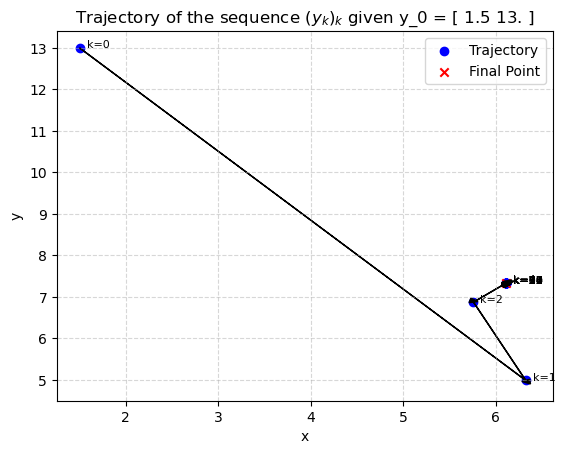

In [11]:
# Plot function to n = 2 case
def plot_trajectory_plane(Seq_SolutionTrial, title):
    # Extract x and y coordinates from the list of solutions
    x_values = [point[0] for point in Seq_SolutionTrial]
    y_values = [point[1] for point in Seq_SolutionTrial]

    # Create the scatter plot with grid
    plt.scatter(x_values, y_values, c='blue', marker='o', label='Trajectory')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Highlight the final point of the trajectory
    final_point = Seq_SolutionTrial[-1]
    plt.scatter(final_point[0], final_point[1], c='red', marker='x', label='Final Point')

    # Add labels with iteration numbers
    for i, point in enumerate(Seq_SolutionTrial[:-1]):
        plt.text(point[0], point[1], f'  k={i}', fontsize=8, color='black')
        # Add arrows from k to k+1
        plt.arrow(point[0], point[1], Seq_SolutionTrial[i+1][0] - point[0], Seq_SolutionTrial[i+1][1] - point[1],
                  head_width=0.1, head_length=0.1, fc='black', ec='black')

    # Labels and title of the plot
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    # Show legend
    plt.legend()

    # Show the plot
    plt.show()

# Using the function with Seq_SolutionTrial
plot_trajectory_plane(Seq_SolutionTrial, "Trajectory of the sequence $(y_k)_k$ given " + "y_0 = " + str(y_0))

#### Algorithm Approach 2 with CVXPY (for convex-programming)

In [4]:
import cvxpy as cp

def AlgorithmApproach2_CVXPY(n, x, y_0, h, beta, gamma, eps):
    """ Perform Approach 2 for solving the optimization problem C = R_{-}^m using CVXPY.

    Parameters:
    - n (int): Dimension of the optimization variable.
    - x (array): Input data for the optimization problem, expected to be projected onto h^{-1}(C).
    - y_0 (array): Initial guess for the optimization variable.
    - h (function): Function to evaluate the optimization variable h(y) in C.
    - beta (float): Parameter for the optimization problem.
    - gamma (function): Function to calculate the gamma parameter.
    - eps (float): Tolerance for stopping the optimization.

    Returns:
    - y_optimal (array): Optimized variable that minimizes the objective function.
    - y_values (list): Sequence of optimized variables throughout the iterations. """
    
    # Initial iteration
    k = 0
    convergenceCondition = True
    
    # CVXPY variable for optimization
    y = cp.Variable(n)
    
    # Define the differential Dh(\cdot) using autograd Jacobian approximation of the given h(x) function
    Dh = ag.jacobian(h)
        
    # Objective function
    objective_initial = 0.5 * cp.sum_squares(x - y) + (0.5 / gamma(k)) * cp.sum_squares(cp.pos(h(y_0) + Dh(y_0) @ (y - y_0))) + beta * cp.sum_squares(y - y_0)

    # Create the CVXPY problem
    problem = cp.Problem(cp.Minimize(objective_initial))
    
    # Solve the CVXPY problem
    problem.solve()
    
    # List to construct sequence (y_n)
    y_values = [y_0]

    # Solve the optimization problem until convergence
    while convergenceCondition:
        # Update the iteration counter
        k += 1
    
        # Update y_{k} = y_{k+1} and \gamma_k in each iteration
        y_k = y.value
        
        # Update the objective function for the new iteration, cp.pos the is positive part
        objective = 0.5 * cp.sum_squares(x - y) + (0.5 / gamma(k)) * cp.sum_squares(cp.pos(h(y_k) + Dh(y_k) @ (y - y_k))) + beta * cp.sum_squares(y - y_k)

        # Update the CVXPY problem
        problem = cp.Problem(cp.Minimize(objective))

        # Solve the updated problem
        problem.solve()

        # Obtain y_{k+1} and save it in the sequence (y_values)
        y_k_plus = y.value
        y_values.append(y_k_plus)

        # Check the convergence condition ||y_{k+1} - y_{k}|| < eps to stop the optimization
        if np.linalg.norm(y_k_plus - y_k) < eps:
            convergenceCondition = False

    # Save last iteration as optimal
    y_optimal = y_k_plus
    print('Solution Obtained: y=', y_optimal, '| Evaluation in h(y) =', h(y_k_plus))
    print('Number of iterations necessary to satisfy the condition ||y_{k+1}-y_{k}|| <', eps, 'are k = ', k)

    # Check if solution satisfies being a feasible point in h^{-1}(C)
    if all(i <= 0.01 for i in h(y_optimal)):
        print("Solution found is: Feasible, lies into h^{-1}(C)")
    else:
        print("Solution found is: Unfeasible, doesn´t lies into h^{-1}(C)")
        
    return y_optimal, y_values

In [6]:
# Testing AlgorithmApproach2 with an old setting using CVXPY

# Parameters
n = 2
m = 2
beta = 0.1
eps = 0.000001
x_given = np.array([1.0,11.0])
y_0 = np.array([100.0, 15.0])

# Function \gamma(k) goes to zero as k -> infty
def gamma(k):
    return (1.0 / (k + 1))

# Parameters of the quadratic forms h_1(x) and h_3(x)
A_1 = np.array([[-0.85738163, -0.6383691],
              [-0.6383691 , 1.85738163]]) #has eigenvalues (-1,2)
b_1 = np.array([1.0, -1.0])
c_1 = -4.0

A_3 = np.array([[-2.99282062, -0.18932872],
                [-0.18932872, 1.99282062]]) #has eigenvalues (-3,2)
b_3 = np.array([2.0,-7.0])
c_3 = 50.0

# Define new weakly convex restriction h_3(x)
def h_1(x):
    return h(x,A_1, b_1, c_1)

def h_3(x):
    return h(x,A_3, b_3, c_3)

# Define h: R^2 -> R^{2} using h_1(x) and h_3(x)
def h_function(x):
    return np.array([h_1(x), h_3(x)])

# Test to see if setting is convex for CVXPY

y_test = cp.Variable(n)
y_k_test = np.ones(n)
Dh_test = ag.jacobian(h_function)
gamma_k = gamma(2)

objective = (0.5 * cp.sum_squares(x_given - y_test)) + (0.5 / gamma_k) * cp.sum_squares(cp.pos(h_function(y_k_test) + Dh_test(y_k_test) @ (y_test - y_k_test))) + beta * cp.sum_squares(y_test - y_k_test)

# Print
header = "Test of Convexity:"
width = 50
print(header.center(width, '='))
print("Expression curvature =", objective.curvature)
print("Expression Sign =", objective.sign)
print("Expression is DCP?", objective.is_dcp())

# Solve
SolutionTrialCVXPY, Seq_SolutionTrialCVXPY = AlgorithmApproach2_CVXPY(n, x_given, y_0, h_function, beta, gamma, eps)

================Test of Convexity:================
Expression curvature = CONVEX
Expression Sign = NONNEGATIVE
Expression is DCP? True
Solution Obtained: y= [6.11373401 7.32441258] | Evaluation in h(y) = [0.00146479 0.00053524]
Number of iterations necessary to satisfy the condition ||y_{k+1}-y_{k}|| < 1e-06 are k =  226
Solution found is: Feasible, lies into h^{-1}(C)


**Fact**: Projection into [h_w(x) < 0] given x = [ 1 11] is: [6.11373177 7.32423638]

#### Comentary: In approach 2, both Scipy and CVXPY solves the problem in that particular cases, approach 1 diverges to infinity, function $d_{C}(x)$ is not Lipschitz when $C = \mathbb{R}_{-}^{m}$

### Testing with the solutions of the composite problems

We consider
$$
\min_{y\in \mathcal{H}}\frac{1}{2}\Vert x-y\Vert^2+\frac{1}{2\gamma}d_{C}^2(h(y)),
$$
as $\gamma \to 0$, for which, given $\gamma > 0$, the solution $y_{\gamma}$ satisfies

$$
\|x-y_\gamma\|^2 + \frac{1}{\gamma}d_{C}^2(h(y_\gamma))\leq d_{h^{-1}(C)}^2(x)
$$
So, the cluster points of $(y_\gamma)$ are minimizers of (1), then if (1) has only one solution, then $(y_\gamma)$ converges to it since it is bounded.


We recall that 
$$d_{R_{-}^{m}}^{2}(x) = ||[x]_{+}||_{\mathbb{R}^{m}}^{2} = \sum_{i=1}^{m} max(0,x_i)^{2}$$

### Algorithm: Composite Sequence

In [14]:
from scipy.optimize import minimize

# Algorithm: Composite Sequence

def CompositeSequence(n, x, y_0, h, gamma, eps, method = "BFGS"):
    """ 
    **Solve sequence of composite problems and return (y_gamma)**

    Parameters:
    - n (int): Dimension of the optimization variable.
    - x (array): Input data for the optimization problem, we expect x to be projected onto h^{-1}(C).
    - y_0 (array): Initial guess for the optimization variable.
    - h (function): Function to evaluate the optimization variable h(y) \in C, must have input an n-dimensional numpy array with output an m-dimensional numpy array.
    - gamma (function): Function to calculate the gamma parameter.
    - eps (float): Tolerance for stopping the optimization.
    - method (str): Optimization method to use (default is "BFGS").

    Returns:
    - y_values (list): Sequence of optimized variables throughout the iterations.
    """
    
    # Auxiliary Functions
    # Function [x]_{+} 
    def positive_part(x):
        return np.maximum(0, x)
    
    # Initial iteration
    k = 0
    convergenceCondition = True
    y_values = [y_0]
    
    # Objective function of problem (P_k), solve (P_k) problem to obtain y_{k+1}
    def F_k(y):
        return 0.5 * np.linalg.norm(x-y)**2 + (0.5/gamma(k))* np.linalg.norm(positive_part(h(y)))**2
        
    # Initial guess for optimization
    x_0 = np.random.uniform(-15, 15, size=(n,))
        
    # Solve problem (P_k) with Scipy, default is "BFGS"
    P_k = minimize(F_k, x_0, method= method)
        
    # Obtain y_{k} and save it in the sequence (y_values)
    y_k = P_k.x
    y_values.append(y_k)
    
    # Start iterating the algorithm
    while convergenceCondition: 
        # Update the iteration counter
        k += 1
        
        # Objective function of problem (P_k), solve (P_k) problem to obtain y_{k+1}
        def F_k(y):
            return 0.5 * np.linalg.norm(x-y)**2 + (0.5/gamma(k))* np.linalg.norm(positive_part(h(y)))**2
        
        # Initial guess for optimization
        x_0 = np.random.uniform(-15, 15, size=(n,))
        
        # Solve problem (P_k) with Scipy, default is "BFGS"
        P_k = minimize(F_k, x_0, method= method)
        
        # Obtain y_{k} and save it in the sequence (y_values)
        y_k = P_k.x
        y_values.append(y_k)
        
        # Check if the convergence condition ||y_{k+1} - y_{k}|| < eps to stop the optimization
        if np.linalg.norm(y_values[-1] - y_values[-2]) < eps:
            convergenceCondition = False
            print('Solution Obtained: y=', y_values[-1], '| Evaluation in h(y) =', h(y_values[-1]))
            print('Number of iterations necessary to satisfy the condition ||y_{k+1}-y_{k}|| <', eps, 'are k =', k, 'with the optimization method:', method)
            
            # Check if solution satisfies being a feasible point in h^{-1}(C)
            if all(i <= 0.01 for i in h(y_values[-1])):
                print("Solution found is: Feasible, lies into h^{-1}(C)")
            else:
                print("Solution found is: Unfeasible, doesn´t lies into h^{-1}(C)")
        
        # If sequence is not converging, then break while condition
        elif k > 1000:
            break
        
    return y_values

### Testing Composite Sequence Algorithm

Solution Obtained: y= [6.11383816 7.32487414] | Evaluation in h(y) = [0.00455249 0.00166562]
Number of iterations necessary to satisfy the condition ||y_{k+1}-y_{k}|| < 1e-05 are k = 72 with the optimization method: BFGS
Solution found is: Feasible, lies into h^{-1}(C)


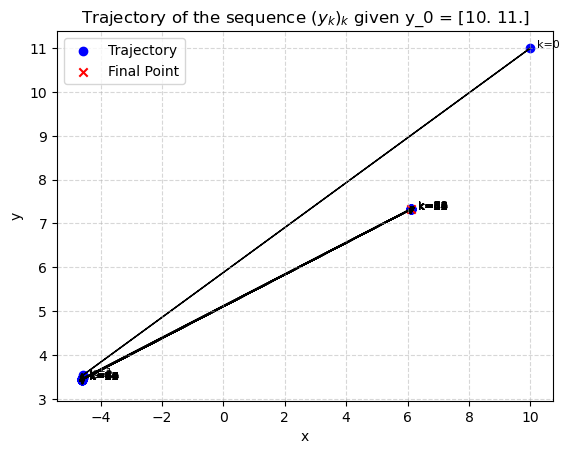

In [15]:
# Parameters
n = 2
m = 2
eps = 0.00001
x_given = np.array([1.0,11.0])
y_0 = np.array([10.0, 11.0])

# Function \gamma(k) goes to zero as k -> infty
def gamma(k):
    return 1.0 / (k + 1)

# Parameters of the quadratic forms h_1(x) and h_3(x)
A_1 = np.array([[-0.85738163, -0.6383691],
              [-0.6383691 , 1.85738163]]) #has eigenvalues (-1,2)
b_1 = np.array([1.0, -1.0])
c_1 = -4.0

A_3 = np.array([[-2.99282062, -0.18932872],
                [-0.18932872, 1.99282062]]) #has eigenvalues (-3,2)
b_3 = np.array([2.0,-7.0])
c_3 = 50.0

# Define new weakly convex restriction h_3(x)
def h_1(x):
    return h(x,A_1, b_1, c_1)

def h_3(x):
    return h(x,A_3, b_3, c_3)

# Define h: R^2 -> R^{2} using h_1(x) and h_3(x)
def h_function(x):
    return np.array([h_1(x), h_3(x)])

# Obtaing sequence (y_gamma) given the function gamma(k)
y_values = CompositeSequence(n, x_given, y_0, h_function, gamma, eps, method = "BFGS")

# Plotting the sequence (y_gamma)
plot_trajectory_plane(y_values, "Trajectory of the sequence $(y_k)_k$ given " + "y_0 = " + str(y_0))

In [16]:
# Printing the sequence
#print(y_values)

**Commentary:** Sequence appears to have clusters point $(-4.58906004,  3.44470446)$ and $(6.11405734, 7.32584738)$, but in this case, given $x = (1,11)$ the solution is unique and is $(6.11405734, 7.32584738)$

In [17]:
# Checking uniqueness
proj = np.array([6.11405734, 7.32584738])
false_proj = np.array([-4.58906004,  3.44470446])
print("Distance: ||x-proj|| = " , np.linalg.norm(x_given - proj))
print("Distance: ||x-(-4.5890,  3.4447)|| = ", np.linalg.norm(x_given - false_proj))

Distance: ||x-proj|| =  6.297061215508449
Distance: ||x-(-4.5890,  3.4447)|| =  9.39787650628953


### Recall: Projection onto $h^{-1}(\mathbb{R}_{-}^{2})$ given $x = (1.0, 11.0)$, in this case $proj_{h^{-1}(C)} (x) = (6.11373177, 7.32423638)$ and the point (-4.58906004,  3.44470446) using Geogebra for Approach 2
<img src="img/false_proj.png" alt="Drawing" style="width: 1000px;"/>